# Analyzing Accuracy

Answer Question: Are certain nutrients easier to predict?

Goal: Inform decision for selecting a justifiable accuracy threshold for each nutrient

1. Plot accuracy vs. threshold for each nutrient
2. Plot accuracy vs. threshold for each prompting strategy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def compute_acc_vs_percent(path, nutrient, max_thresh):
    df = pd.read_json(path, lines=True)

    mae = pd.json_normalize(df["result"])["mae"].to_numpy()
    gt = pd.json_normalize(df["doc"])[nutrient].to_numpy()

    # Normalize MAE (avoid division by zero)
    eps = 1e-8
    norm_mae = mae / (gt + eps)

    interval = max_thresh / 250
    thresholds = np.arange(0, max_thresh + interval, interval)
    acc = np.array([(norm_mae < t).mean() for t in thresholds])

    thresholds_percent = thresholds * 100  

    return acc, thresholds_percent

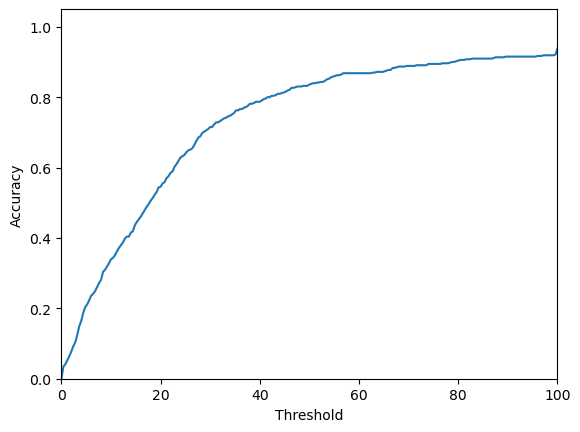

In [12]:
path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_base_20250722_043618.jsonl"
max_threshold = 1

carb_acc, thresholds = compute_acc_vs_percent(path, "carb", max_threshold)

plt.plot(thresholds, carb_acc, label="Accuracy vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.xlim(0, 100)
plt.tight_layout
plt.legend
plt.show()

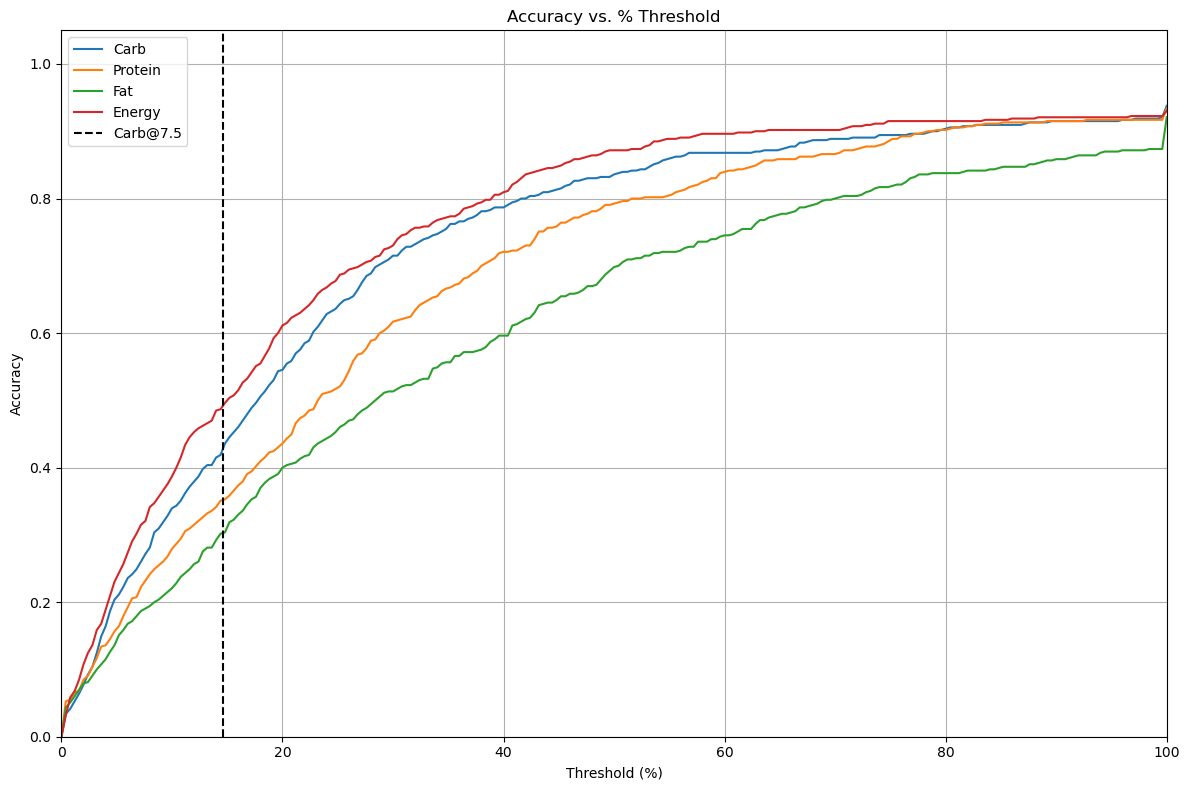

In [ ]:
files = {
    "carb": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_base_20250722_043618.jsonl",
    "protein": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_protein_base_20250719_192710.jsonl",
    "fat": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_fat_base_20250719_184222.jsonl",
    "energy": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_energy_base_20250721_222318.jsonl",
}
max_thresh = 1

accs = {}
for key in files:
    acc, thresh = compute_acc_vs_percent(files[key], key, max_thresh)
    accs[key] = [acc, thresh]

plt.figure(figsize=(12, 8))

for key in accs:
    acc, thresh = accs[key]
    plt.plot(thresh, acc, label=key.capitalize())

carb_norm_thresh = 7.5 / 51.236981 * 100
plt.axvline(x=carb_norm_thresh, color='black', linestyle='--', label="Carb@7.5")

plt.xlabel("Threshold (%)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. % Threshold")
plt.ylim(0, 1.05)
plt.xlim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Energy > Carb > Protein > Fat

Matches order of expected best to worst LLM prediction accuracy given by GPT-4o

Next, investigate constant thresholds (normalized by average gt)

In [6]:
def compute_acc_vs_thresh(path, max_thresh):
    df = pd.read_json(path, lines=True)
    mae = pd.json_normalize(df["result"])["mae"].to_numpy()

    interval = max_thresh / 250
    thresholds = np.arange (0, max_thresh + interval, interval)
    acc = np.array([(mae < t).mean() for t in thresholds])

    return acc, thresholds

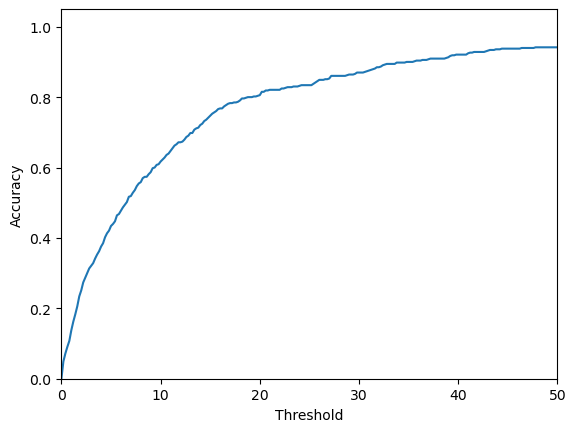

In [7]:

path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_base_20250722_043618.jsonl"
max_threshold = 50

acc, thresholds = compute_acc_vs_thresh(path, max_threshold)

plt.plot(thresholds, acc, label="Accuracy vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.xlim(0, max_threshold)
plt.tight_layout
plt.legend
plt.show()

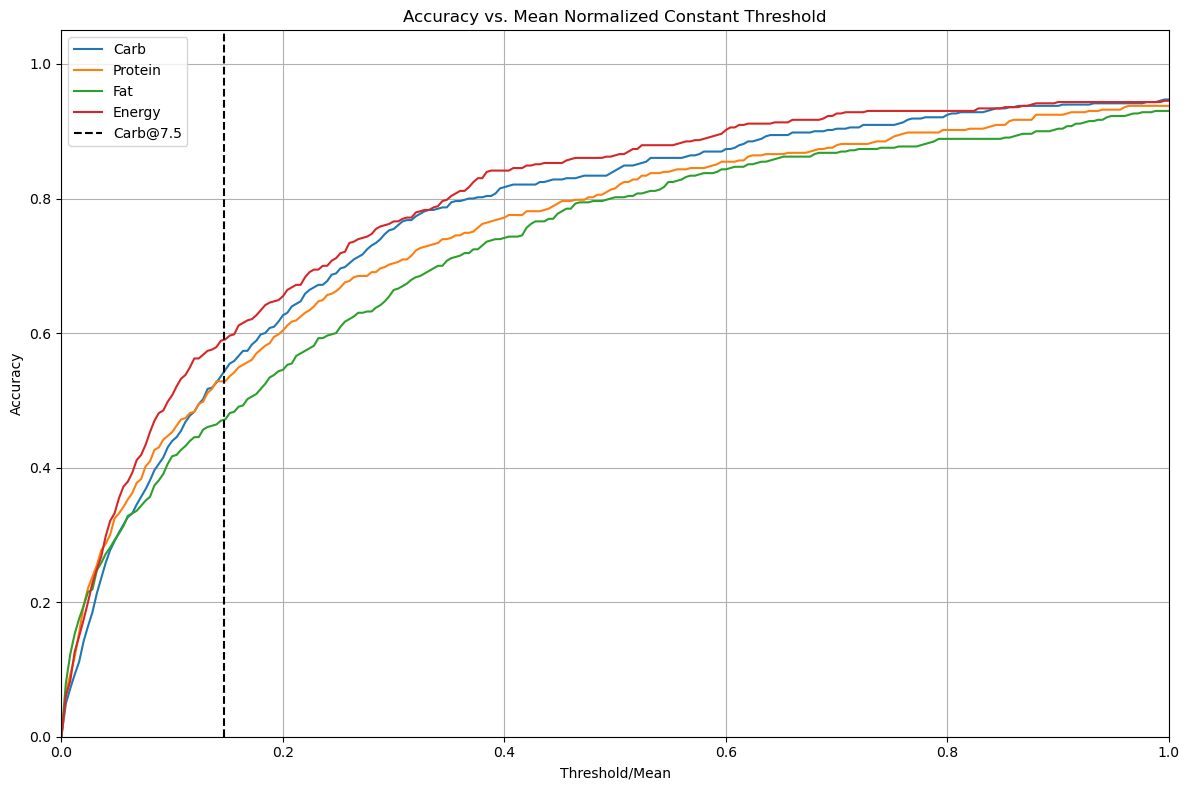

In [8]:
files = {
    "carb": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_base_20250722_043618.jsonl",
    "protein": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_protein_base_20250719_192710.jsonl",
    "fat": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_fat_base_20250719_184222.jsonl",
    "energy": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_energy_base_20250721_222318.jsonl",
}

# average values in subset
max_thresh = {
    "carb": 51.236981,
    "protein": 12.143283,
    "fat": 13.454717,
    "energy": 370.127377
    }

accs = {}
for key in files:
    acc, thresh = compute_acc_vs_thresh(files[key], max_thresh[key])
    thresh = thresh / max_thresh[key]
    accs[key] = [acc, thresh]

plt.figure(figsize=(12, 8))

for key in accs:
    acc, thresh = accs[key]
    plt.plot(thresh, acc, label=key.capitalize())

carb_norm_thresh = 7.5 / 51.236981
plt.axvline(x=carb_norm_thresh, color='black', linestyle='--', label="Carb@7.5")

plt.xlabel("Threshold/Mean")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Mean Normalized Constant Threshold")
plt.ylim(0, 1.05)
plt.xlim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Carb acc vs percent for each prompting strategy

In [9]:
def compute_acc_vs_percent_comb(path, nutrient, max_thresh):
    df = pd.read_json(path, lines=True)

    mae = pd.json_normalize(df["result"])[nutrient + ".mae"].to_numpy()
    gt = pd.json_normalize(df["doc"])[nutrient].to_numpy()

    # Normalize MAE (avoid division by zero)
    eps = 1e-8
    norm_mae = mae / (gt + eps)

    interval = max_thresh / 250
    thresholds = np.arange(0, max_thresh + interval, interval)
    acc = np.array([(norm_mae < t).mean() for t in thresholds])

    return acc, thresholds

In [42]:
def plot_acc_v_pcnt_prompts(nutrient, base, cot, comb, comb_cot):
    acc, thresh = compute_acc_vs_percent(base, nutrient, 2)
    cot_acc, _ = compute_acc_vs_percent(cot, nutrient, 2)
    comb_acc, _ = compute_acc_vs_percent_comb(comb, nutrient, 2)
    comb_cot_acc, _ = compute_acc_vs_percent_comb(comb_cot, nutrient, 2)

    plt.figure(figsize=(12, 8))
    plt.plot(thresh, acc, label="Base")
    plt.plot(thresh, cot_acc, label="CoT")
    plt.plot(thresh, comb_acc, label="Combined-base")
    plt.plot(thresh, comb_cot_acc, label="Combined-CoT")

    carb_norm_thresh = 7.5 / 51.236981
    plt.axvline(x=carb_norm_thresh, color='black', linestyle='--', label="Carb@7.5")

    plt.xlabel("Threshold (%)")
    plt.ylabel("Accuracy")
    plt.title(nutrient.capitalize() + " Accuracy vs. % Threshold")
    plt.ylim(0, 1.05)
    plt.xlim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

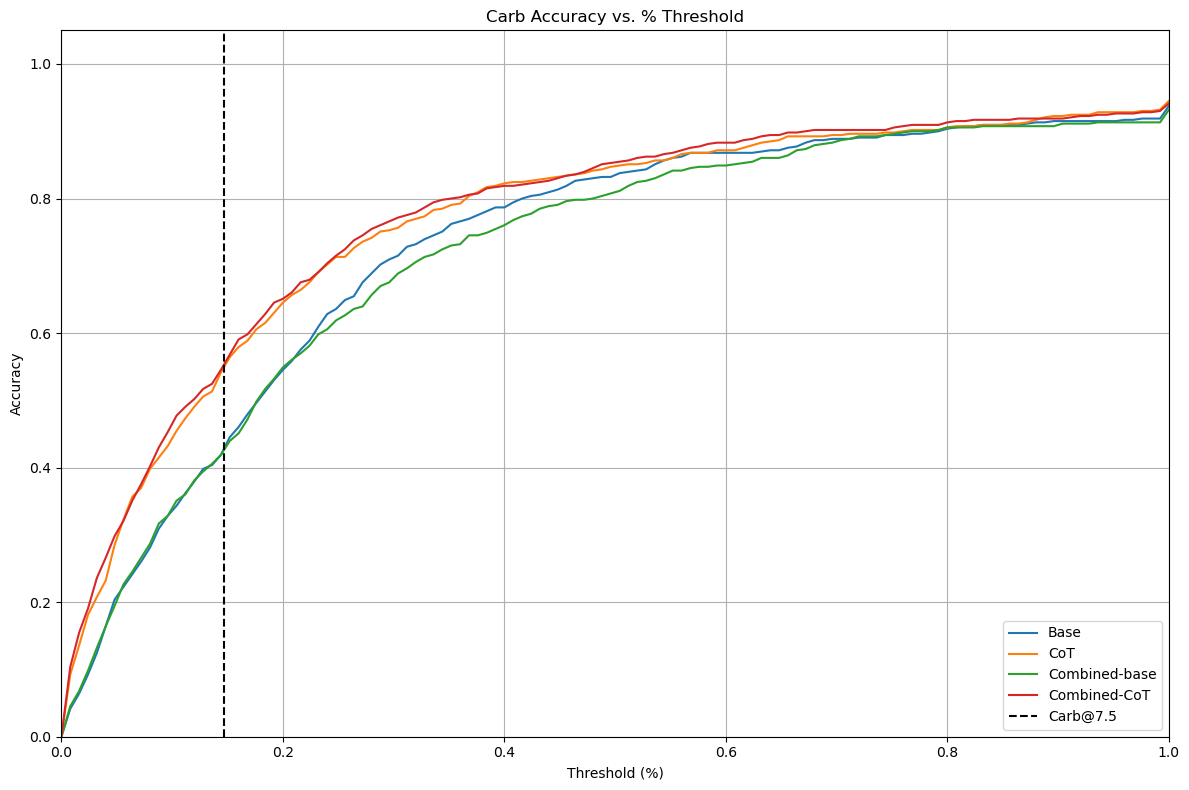

In [ ]:
base = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_base_20250722_043618.jsonl"
cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_CoT_20250719_051735.jsonl"
comb = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_base_20250719_194516.jsonl"
comb_cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_CoT_20250720_064149.jsonl"

plot_acc_v_pcnt_prompts("carb", base, cot, comb, comb_cot)

Carb acc vs threshold for each prompting strategy

In [44]:
def compute_acc_vs_thresh_comb(path, nutrient, max_thresh):
    df = pd.read_json(path, lines=True)
    mae = pd.json_normalize(df["result"])[nutrient + ".mae"].to_numpy()

    interval = max_thresh / 250
    thresholds = np.arange (0, max_thresh + interval, interval)
    acc = np.array([(mae < t).mean() for t in thresholds])

    return acc, thresholds

In [50]:
def plot_acc_v_thresh_prompts(nutrient, base, cot, comb, comb_cot):
    max_thresh = {
        "carb": 51.236981,
        "protein": 12.143283,
        "fat": 13.454717,
        "energy": 370.127377
    }
    
    max_t = max_thresh[nutrient]

    acc, thresh = compute_acc_vs_thresh(base, max_t)
    cot_acc, _ = compute_acc_vs_thresh(cot, max_t)
    comb_acc, _ = compute_acc_vs_thresh_comb(comb, nutrient, max_t)
    comb_cot_acc, _ = compute_acc_vs_thresh_comb(comb_cot, nutrient, max_t)

    thresh = thresh / max_t

    plt.figure(figsize=(12, 8))

    plt.plot(thresh, acc, label="Base")
    plt.plot(thresh, cot_acc, label="CoT")
    plt.plot(thresh, comb_acc, label="Combined-base")
    plt.plot(thresh, comb_cot_acc, label="Combined-CoT")

    carb_norm_thresh = 7.5 / 51.236981
    plt.axvline(x=carb_norm_thresh, color='black', linestyle='--', label="Carb@7.5")

    plt.xlabel("Threshold/Mean")
    plt.ylabel("Accuracy")
    plt.title(nutrient.capitalize() + " Accuracy vs. Mean Normalized Constant Threshold")
    plt.ylim(0, 1.05)
    plt.xlim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    

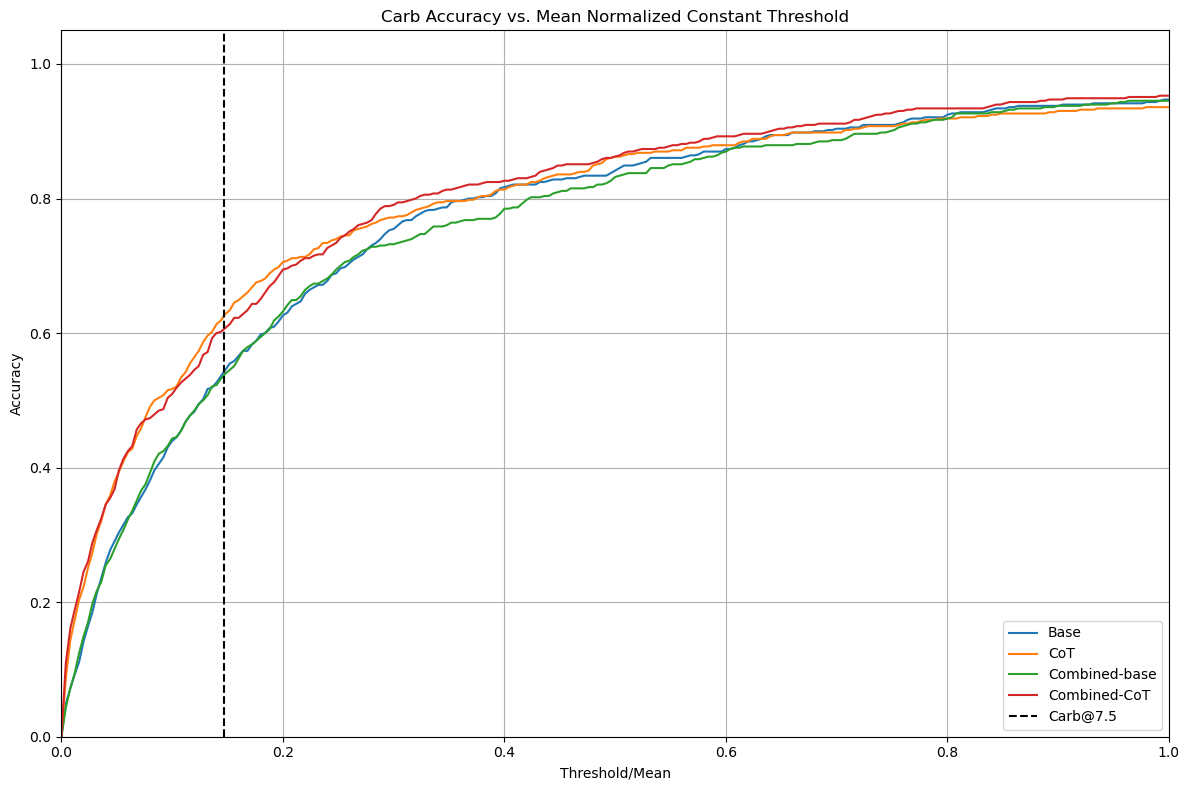

In [ ]:
base = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_base_20250722_043618.jsonl"
cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_CoT_20250719_051735.jsonl"
comb = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_base_20250719_194516.jsonl"
comb_cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_CoT_20250720_064149.jsonl"

plot_acc_v_thresh_prompts("carb", base, cot, comb, comb_cot)

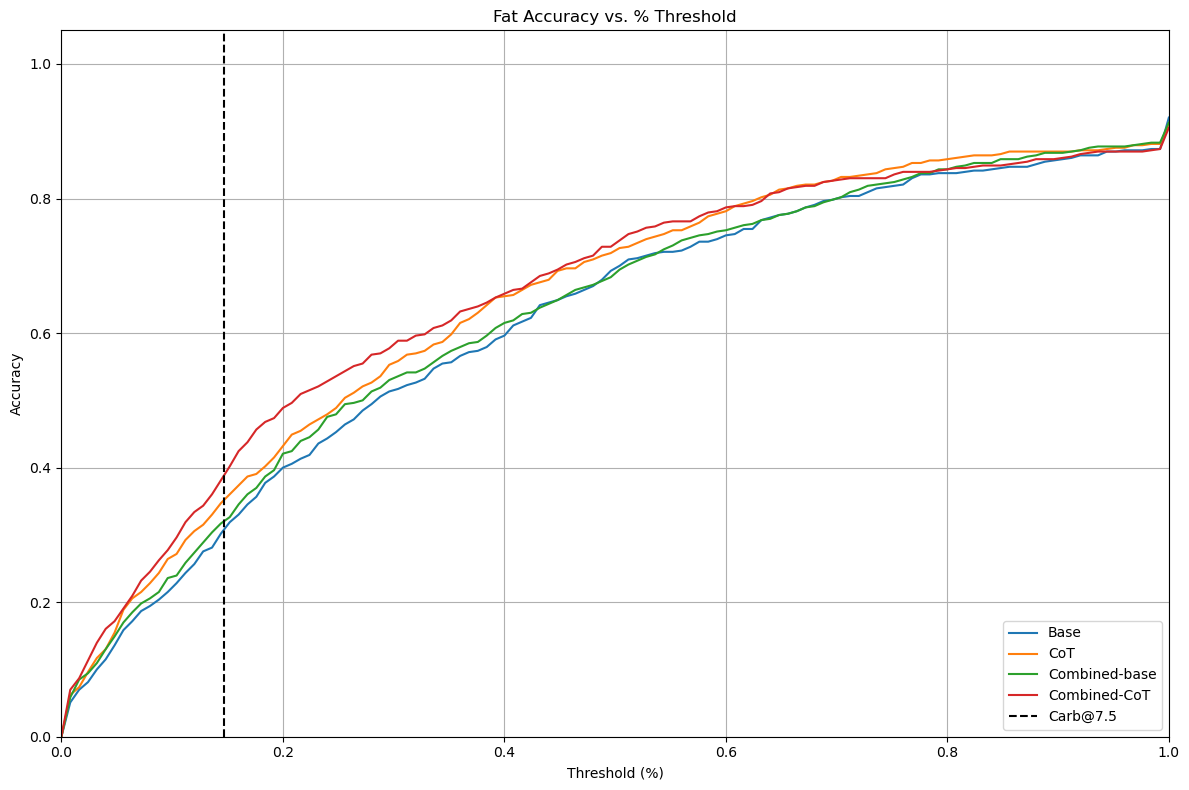

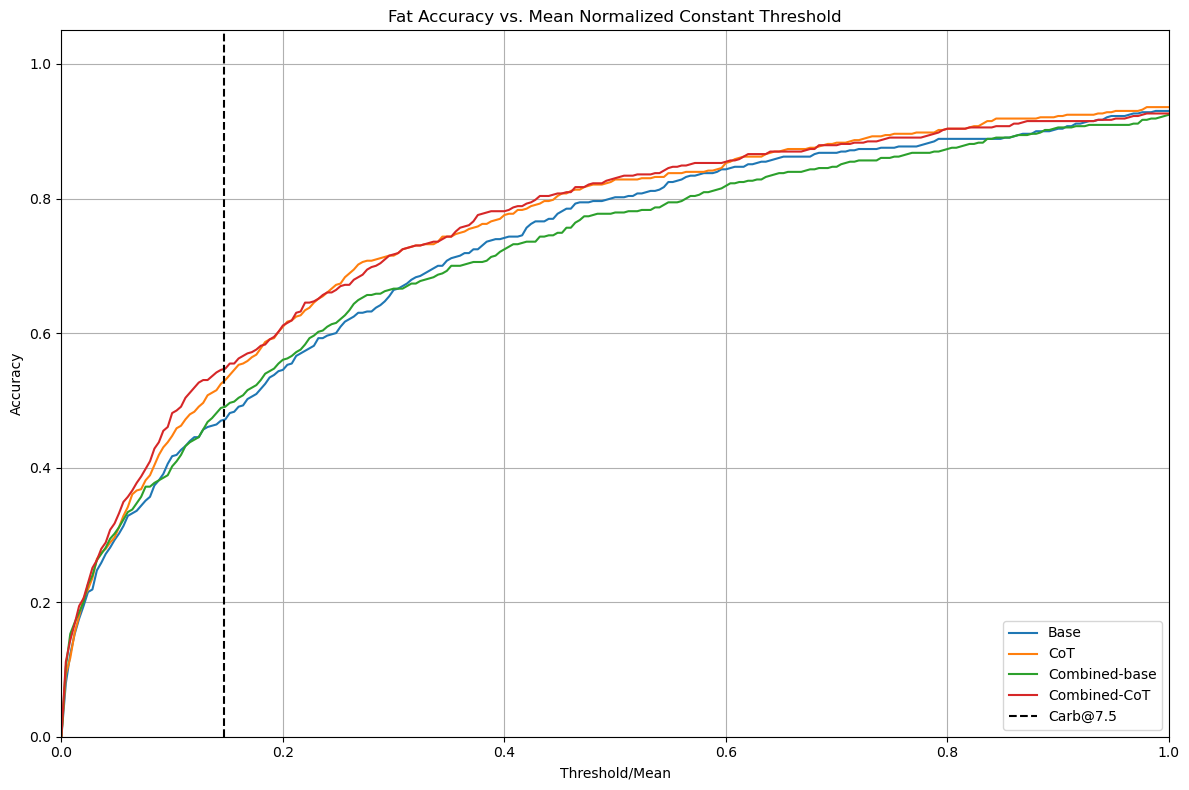

In [ ]:
fat_base = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_fat_base_20250719_184222.jsonl"
fat_cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_fat_CoT_20250720_050526.jsonl"
comb = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_base_20250719_194516.jsonl"
comb_cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_CoT_20250720_064149.jsonl"

plot_acc_v_pcnt_prompts("fat", fat_base, fat_cot, comb, comb_cot)
plot_acc_v_thresh_prompts("fat", fat_base, fat_cot, comb, comb_cot)

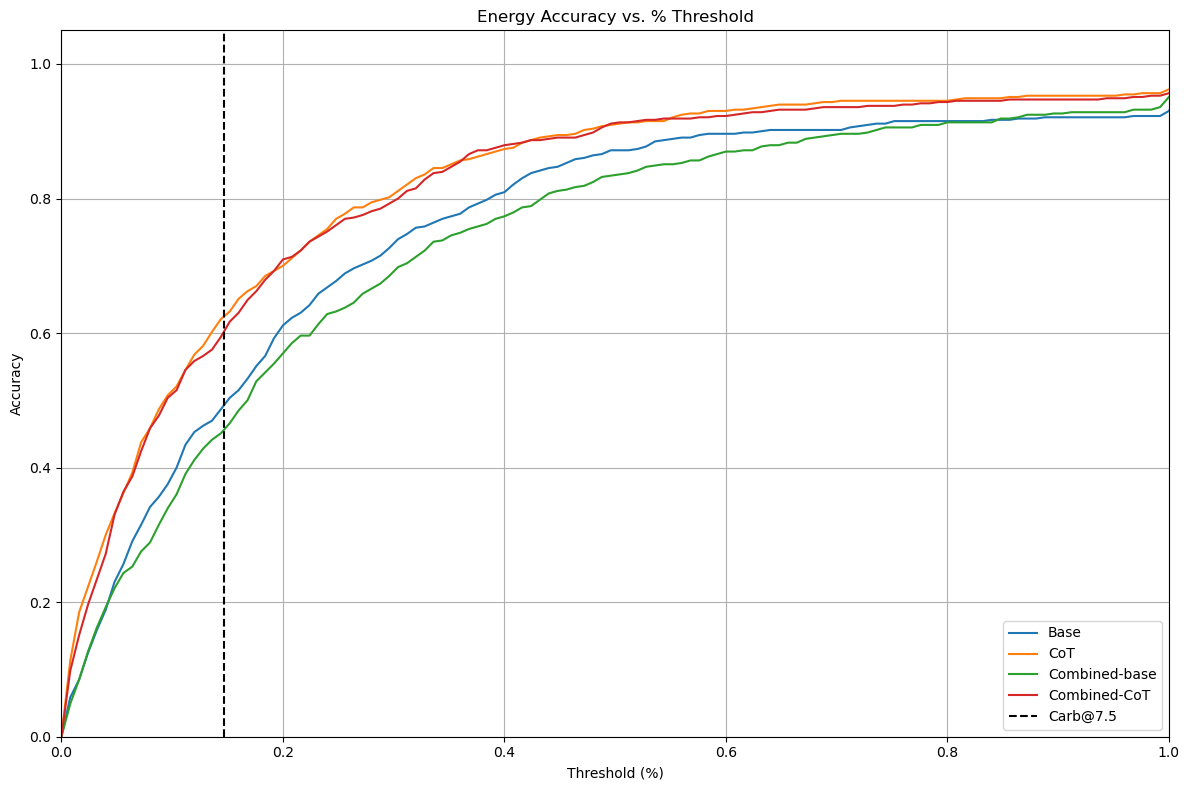

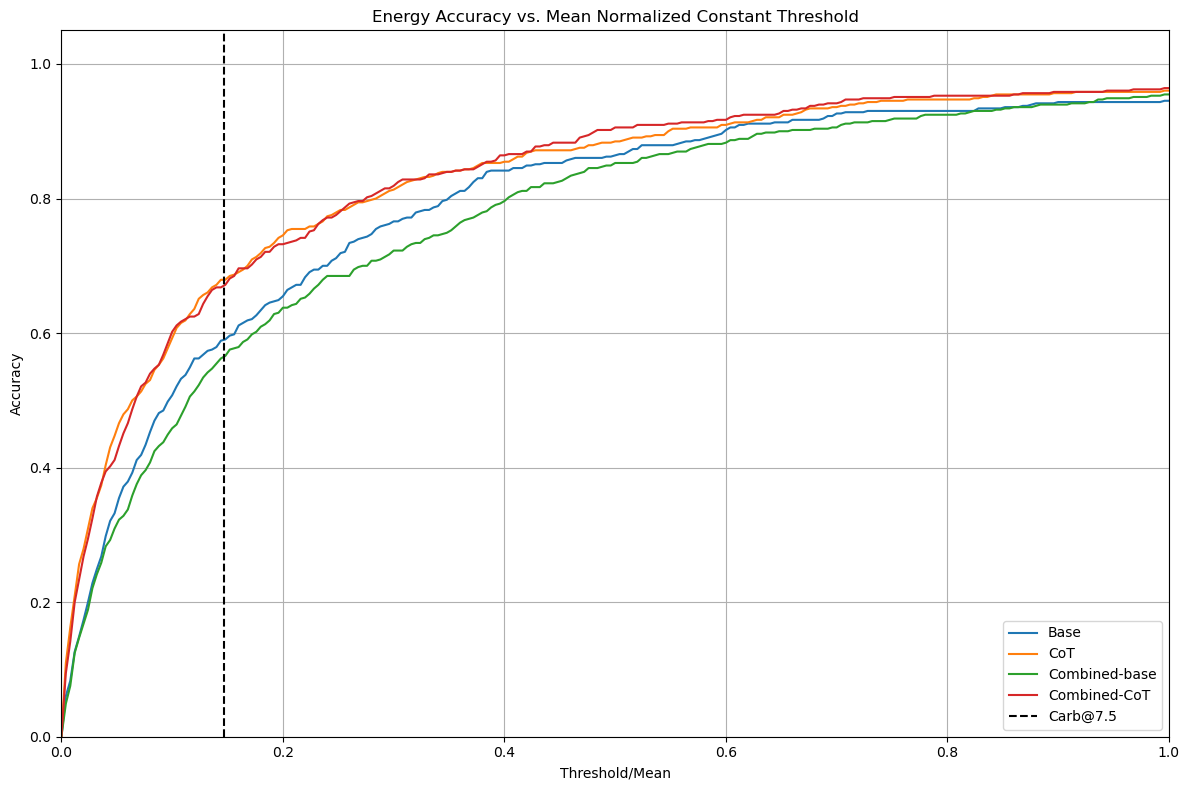

In [54]:
energy_base = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_energy_base_20250721_222318.jsonl"
energy_cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_energy_CoT_20250720_053252.jsonl"
comb = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_base_20250719_194516.jsonl"
comb_cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_CoT_20250720_064149.jsonl"

plot_acc_v_pcnt_prompts("energy", energy_base, energy_cot, comb, comb_cot)
plot_acc_v_thresh_prompts("energy", energy_base, energy_cot, comb, comb_cot)

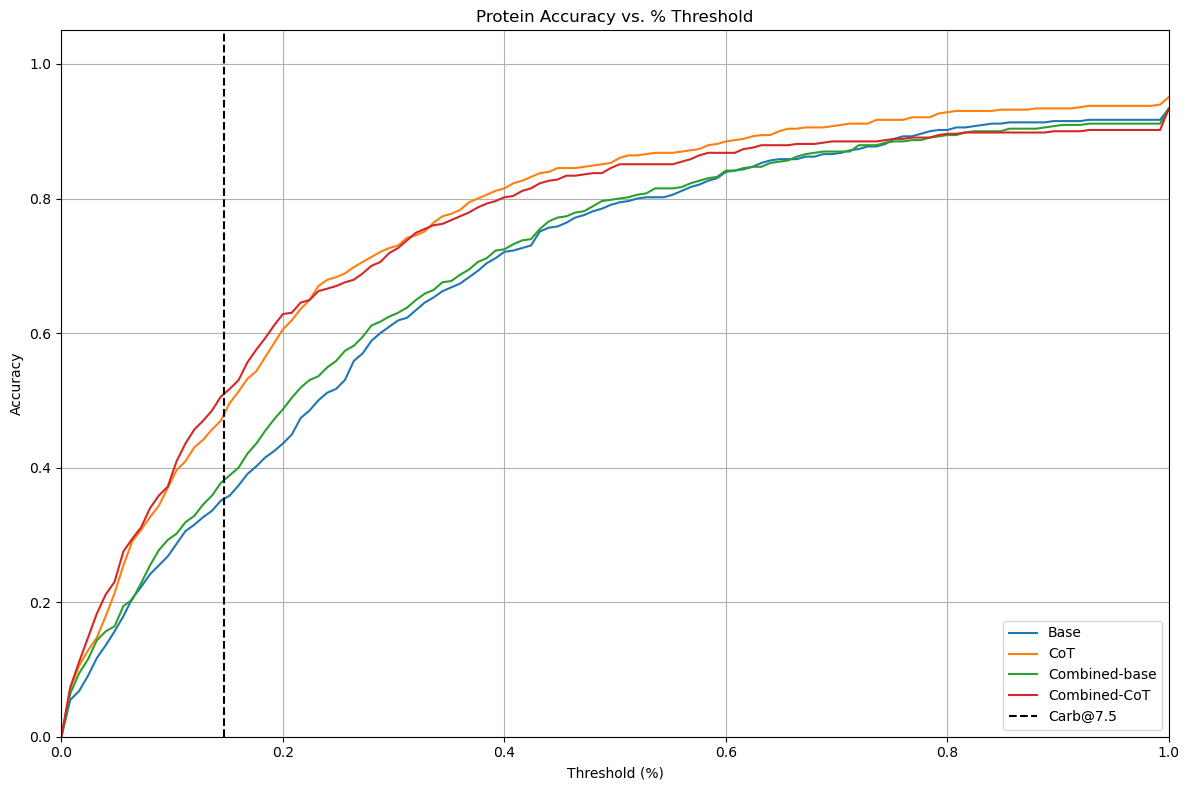

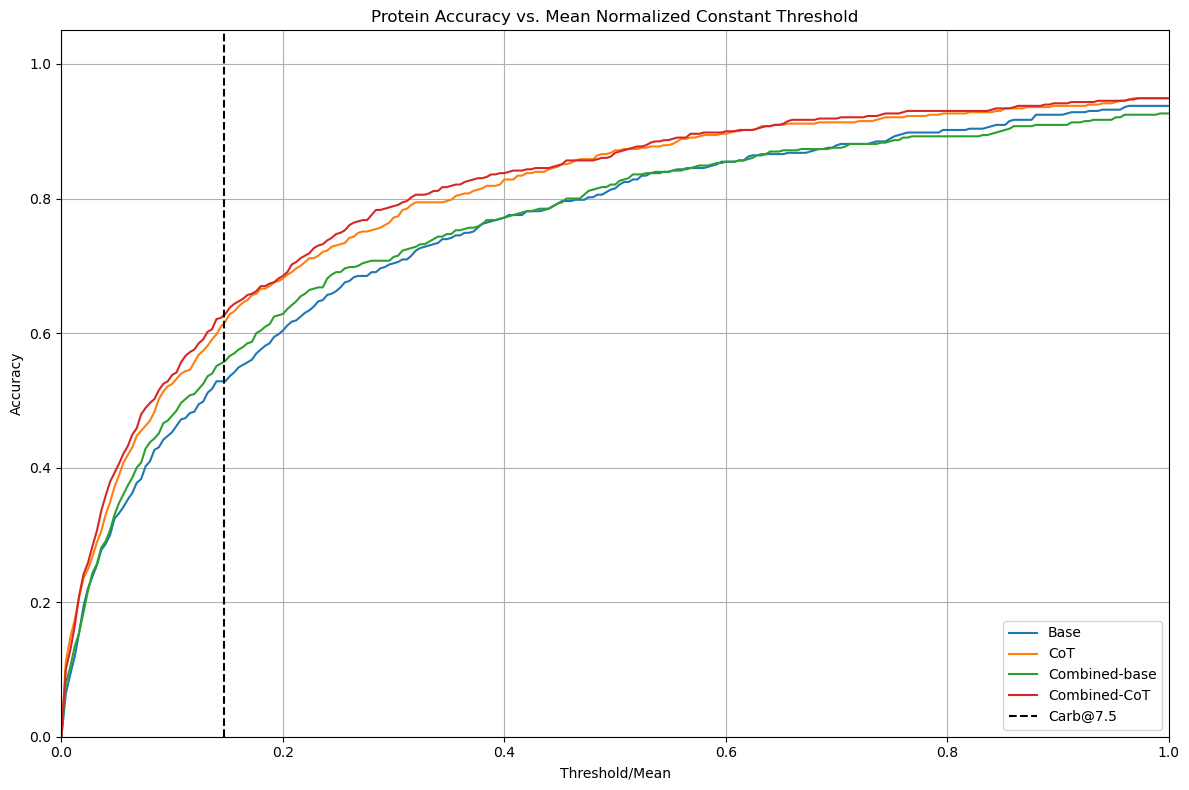

In [56]:
protein_base = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_protein_base_20250719_192710.jsonl"
protein_cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_protein_CoT_20250720_060342.jsonl"
comb = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_base_20250719_194516.jsonl"
comb_cot = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_combined_CoT_20250720_064149.jsonl"

plot_acc_v_pcnt_prompts("protein", protein_base, protein_cot, comb, comb_cot)
plot_acc_v_thresh_prompts("protein", protein_base, protein_cot, comb, comb_cot)

Instead of normalizing by ground truth value or mean nutrient value, standardize the ground truth of each nutrient to N(mean=0, std=1) and apply the same mean/std to the predictions

In [2]:
def compute_acc_vs_zscore(path, nutrient, max_thresh, eps=1e-12, return_stats=False):
    """
    Standardize gt -> (gt - mu_gt)/sigma_gt and apply the same (mu_gt, sigma_gt)
    to predictions, then compute accuracy vs threshold in z-units.
    """

    # Load
    df = pd.read_json(path, lines=True)
    gt = pd.json_normalize(df["doc"])[nutrient].to_numpy(dtype=float)
    pred = df["pred"]

    # Compute standardization stats from gt
    mu_gt = float(np.mean(gt))
    sigma_gt = float(np.std(gt, ddof=0)) 

    # Z-score transform using gt statistics
    z_gt = (gt - mu_gt) / (sigma_gt + eps)
    z_pred = (pred - mu_gt) / (sigma_gt + eps)

    # 5) Compute accuracy vs z-threshold
    z_abs_err = np.abs(z_pred - z_gt)

    interval = max_thresh / 250.0
    thresholds = np.arange(0.0, max_thresh + interval, interval)
    acc = np.array([(z_abs_err < t).mean() for t in thresholds])

    if return_stats:
        return acc, thresholds, (mu_gt, sigma_gt)
    return acc, thresholds

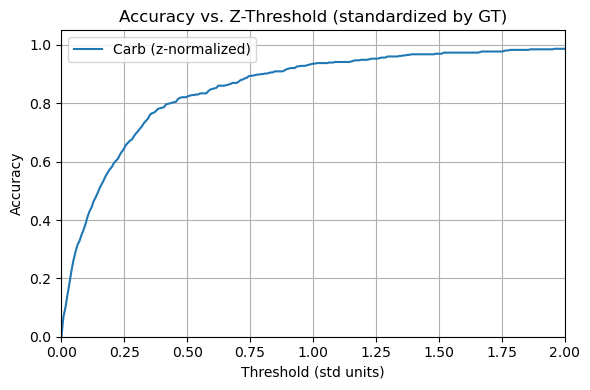

In [4]:
acc_z, thresh_z = compute_acc_vs_zscore(
    "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_base_20250722_043618.jsonl",
    "carb",
    max_thresh=2.0  # e.g., up to 3 standard deviations
)

# Plot (z-threshold on x-axis, accuracy on y-axis)
plt.figure(figsize=(6,4))
plt.plot(thresh_z, acc_z, label="Carb (z-normalized)")
plt.xlabel("Threshold (std units)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Z-Threshold (standardized by GT)")
plt.ylim(0, 1.05)
plt.xlim(0, thresh_z.max())
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

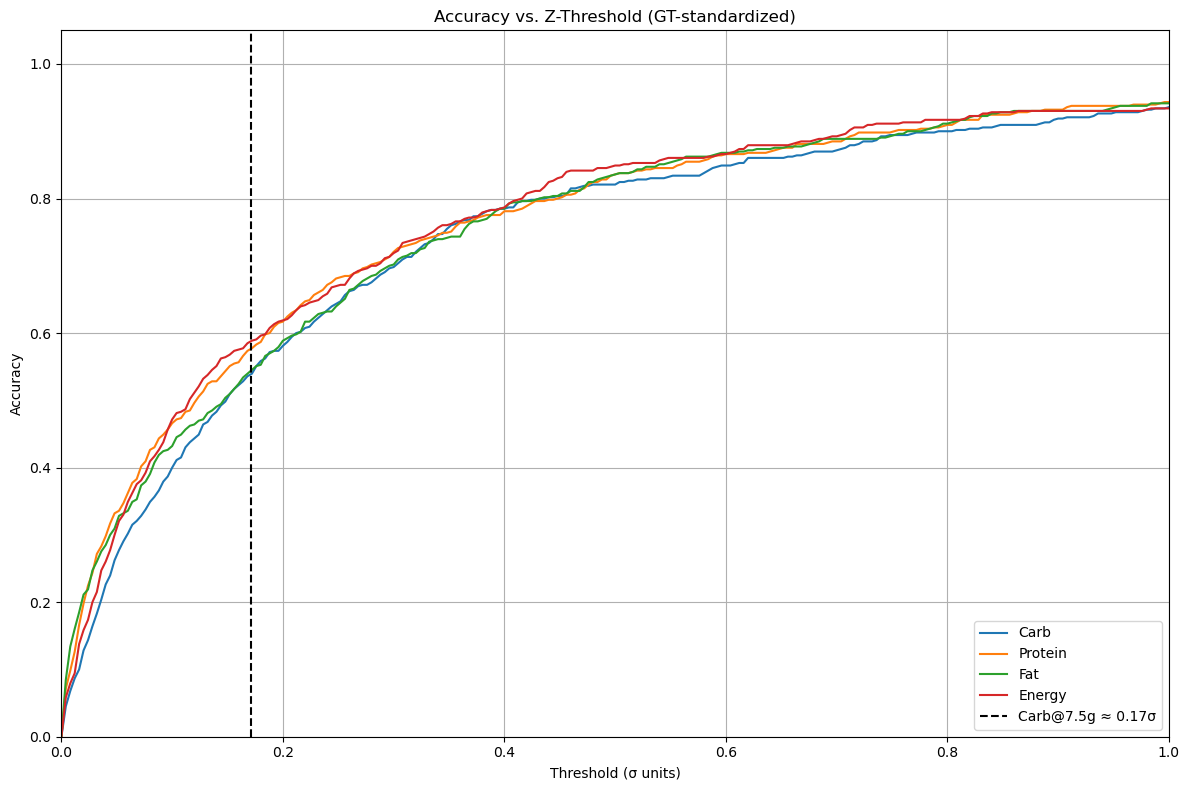

In [6]:
files = {
    "carb": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_base_20250722_043618.jsonl",
    "protein": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_protein_base_20250719_192710.jsonl",
    "fat": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_fat_base_20250719_184222.jsonl",
    "energy": "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_energy_base_20250721_222318.jsonl",
}

# Up to how many standard deviations to sweep on the x-axis
max_z = 1.0

accs = {}
stats = {}

for nut, path in files.items():
    acc, z_thresh, (mu, sigma) = compute_acc_vs_zscore(path, nut, max_z, return_stats=True)
    accs[nut] = (acc, z_thresh)
    stats[nut] = (mu, sigma)

plt.figure(figsize=(12, 8))

# Plot each nutrient’s accuracy vs z-threshold
for nut, (acc, z_thresh) in accs.items():
    plt.plot(z_thresh, acc, label=nut.capitalize())

# Add a vertical marker for an absolute 7.5 g carb error, translated to σ-units
carb_sigma = stats["carb"][1]
carb_z = 7.5 / (carb_sigma + 1e-12)
plt.axvline(x=carb_z, color="black", linestyle="--", label=f"Carb@7.5g ≈ {carb_z:.2f}σ")

plt.xlabel("Threshold (σ units)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Z-Threshold (GT-standardized)")
plt.ylim(0, 1.05)
plt.xlim(0, max_z)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()